In [1]:
import networkx
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import *
from torch_geometric.loader import NeighborSampler, NeighborLoader
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, ResGatedGraphConv, GATv2Conv, SAGEConv, GENConv, DeepGCNLayer, PairNorm, GINConv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import torch.nn.functional as F
from imblearn.under_sampling import RandomUnderSampler
pd.options.mode.use_inf_as_na = True
from collections import Counter
from sklearn.feature_selection import SelectFromModel
import torch.nn as nn
import time
import pickle
from torch.nn import LayerNorm, Linear, ReLU
from torch_scatter import scatter
from tqdm import tqdm
from torch_geometric.loader import RandomNodeSampler
import math
import copy
from sklearn.metrics import f1_score
from torch.optim import lr_scheduler

In [2]:
import warnings
# action参数可以设置为ignore，一位一次也不喜爱你是，once表示为只显示一次
warnings.filterwarnings(action='ignore')

In [3]:
np.random.seed(2022)
torch.manual_seed(2022)

In [4]:
class Transition_layer(torch.nn.Module):
    def __init__(self, act, norm, lin):
        super().__init__()
        self.act = act
        self.norm = norm
        self.lin = lin
    def forward(self, x):
        x = self.norm(x)
        x = self.act(x)
        x = self.lin(x)
        return x
        
class DenseGAT(torch.nn.Module):
    def __init__(self, in_channels, num_class, num_layers=6, num_blocks=3, growth_rate=10, theta=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.blocks = num_blocks
        self.theta = theta
        self.growth_rate = growth_rate
        self.base_rate = growth_rate
        self.in_channels = in_channels
        self.out_channels = num_class
        self.linear_layers = torch.nn.ModuleList()
        self.transition_layers = torch.nn.ModuleList()
        self.block_layers = torch.nn.ModuleList()
        self.node_encoder = Linear(in_channels, in_channels)
        self.linear_layers.append(self.node_encoder)
        
        for i in range(self.blocks):
            # block
            layers = torch.nn.ModuleList()
            # 2^(i - 1) * k0
            self.growth_rate = int(math.pow(2, i) * self.base_rate)
            print(self.growth_rate)
            for j in range(1, self.num_layers + 1):
                conv = GATConv(in_channels + (j - 1) * self.growth_rate, self.growth_rate, aggr='max') 
                norm = LayerNorm(self.growth_rate)
                act = ReLU()
                layer = DeepGCNLayer(conv, norm, act, block='dense')
                layers.append(layer)
            self.block_layers.append(layers)
            
            # transition
            hidden_channels = in_channels +  self.num_layers * self.growth_rate
            out_channels = int(hidden_channels * self.theta)
            transition_norm = LayerNorm(hidden_channels, elementwise_affine=True)
            transition_act = ReLU()
            transition_lin = Linear(hidden_channels, out_channels)
            transitionLayer = Transition_layer(transition_act, transition_norm, transition_lin)
            self.transition_layers.append(transitionLayer)
            in_channels = copy.copy(out_channels)
        
        self.lin_last = Linear(in_channels, self.out_channels)
        self.linear_layers.append(self.lin_last)
        
    def forward(self, x, edge_index):
        for i in range(self.blocks):
            # block layer
            for layer in self.block_layers[i]:
                x = layer(x, edge_index)
            # transition layer
            x = self.transition_layers[i](x)
        x = self.linear_layers[-1](x)
        return x

In [4]:
class DeepGCNLayer(torch.nn.Module):
    def __init__(self, conv=None, norm=None, act=None, block='res+',
                 dropout=0., ckpt_grad=False):
        super().__init__()
        self.conv = conv
        self.norm = norm
        self.act = act
        self.block = block.lower()
        assert self.block in ['res+', 'res', 'dense', 'plain']
        self.dropout = dropout
        self.ckpt_grad = ckpt_grad

    def reset_parameters(self):
        self.conv.reset_parameters()
        self.norm.reset_parameters()

    def forward(self, *args, **kwargs):
        """"""
        args = list(args)
        x = args.pop(0)
        h2 = self.conv(x, *args, **kwargs)
        if self.norm is not None:
            h2 = self.norm(h2)
        if self.act is not None:
            h2 = self.act(h2)
        h = torch.cat([x, h2], dim=-1)
        return F.dropout(h, p=self.dropout, training=self.training), h2 # h是Dense连接后的,h2是聚合输出


    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(block={self.block})'


In [6]:
class ADCGAT(torch.nn.Module):
    def __init__(self, in_channels, num_class, num_layers=6, num_blocks=3, growth_rate=10, theta=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.blocks = num_blocks
        self.theta = theta
        self.growth_rate = growth_rate
        self.base_rate = growth_rate
        self.in_channels = in_channels
        self.out_channels = num_class
        self.linear_layers = torch.nn.ModuleList()
        self.transition_layers = torch.nn.ModuleList()
        self.block_layers = torch.nn.ModuleList()
        self.node_encoder = Linear(in_channels, in_channels)
        self.linear_layers.append(self.node_encoder)
        self.layers = torch.nn.ModuleList()
        self.proj = Linear(growth_rate, 1)
        for j in range(1, self.num_layers + 1):
            conv = GATConv(in_channels + (j - 1) * self.growth_rate, self.growth_rate) 
            norm = LayerNorm(self.growth_rate)
            act = ReLU()
            layer = DeepGCNLayer(conv, norm, act, block='dense')
            self.layers.append(layer)
            
        self.lin_last = Linear(self.growth_rate , self.out_channels)
        self.linear_layers.append(self.lin_last)
        
    def forward(self, x, edge_index):
        pre = []
        for layer in self.layers:
            x, out = layer(x, edge_index)
            pre.append(out)
        preds = torch.stack(pre, 1)
        m = torch.tanh(preds)
        print(m.size())
        retain_score = self.proj(m)
        print(retain_score.size())
        retain_score = torch.softmax(retain_score, 1)
        print(retain_score.size())
        out = preds * retain_score
        out = torch.sum(out, dim=1)
        out = self.linear_layers[-1](out)
        return out

In [36]:
class OriginalGAT(torch.nn.Module):
    def __init__(self, in_channels, num_class, hidden):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.conv1 = GATConv(in_channels, hidden) 
        self.conv2 = GATConv(hidden, num_class) 
        self.act = ReLU()
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.act(x)
        x = self.conv2(x, edge_index)
        return x

In [148]:
class MultiLayerGAT(torch.nn.Module):
    def __init__(self, in_channels, num_class, hidden, k):
        super().__init__()
        self.layer_num = k
        self.layers = torch.nn.ModuleList()
        self.layers.append(GATConv(in_channels, hidden))
        for i in range(k-2):
            self.layers.append(GATConv(hidden, hidden))
        self.layers.append(GATConv(hidden,num_class))
        self.act = ReLU()
        
    def forward(self, x, edge_index):
        for layer in self.layers:
            x = self.act(x)
            x = layer(x, edge_index)
        return x

In [149]:
def train():
    total_loss = total_correct = total_examples = 0
    start_time = time.time()
    for batch in train_loader:
        batch = batch.to(device)
        y = batch.y[:batch.batch_size]
        optimizer.zero_grad()
        y_hat = model(batch.x.to(device), batch.edge_index.to(device))[:batch.batch_size]
        loss = F.cross_entropy(y_hat, y)
        loss.backward()
        optimizer.step()
#         scheduler1.step()
        total_loss += float(loss) * batch.batch_size
        total_correct += int((y_hat.argmax(dim=-1) == y).sum())
        total_examples += batch.batch_size
    end_time = time.time()  
    
    return total_loss / total_examples, total_correct / total_examples

def inferrence(model, subgraph_loader):
    total_loss = total_correct = total_examples = 0
    xs = []
    y = []
    pbar = tqdm(total=len(subgraph_loader))
    for batch in subgraph_loader:
        y_hat = model(batch.x, batch.edge_index.to(device))[:batch.batch_size]
        xs.append(y_hat.cpu())
        y_true = batch.y[:batch.batch_size]
        y.append(y_true.cpu())
        pbar.update(1)
    pbar.close()
    y_hat = torch.cat(xs, 0)
    y_hat = y_hat.detach().numpy()
    y_hat = np.argmax(y_hat, -1)
    y = torch.cat(y, 0)
    print(y_hat)
    print(y)
    cr1 = classification_report(y, y_hat,digits=4)
    cf = confusion_matrix(y, y_hat)
    print(cr1)
    print(cf)


In [93]:
train_data = torch.load('cic2017_directed_line_graph_train_data_15label2')
test_data = torch.load('cic2017_directed_line_graph_test_data_15label2')

In [8]:
train_data = torch.load('cic2017_dgl_to_pyg_train_data50')

In [9]:
test_data = torch.load('cic2017_dgl_to_pyg_test_data50')

In [11]:
# train_data = torch.load('cic2017_dgl_to_pyg_train_data50')

In [12]:
# test_data = torch.load('cic2017_dgl_to_pyg_test_data50')

In [94]:
train_data,test_data

(Data(x=[424589, 78], edge_index=[2, 156754252], y=[424589], num_nodes=424589),
 Data(x=[181967, 78], edge_index=[2, 31672070], y=[181967], num_nodes=181967))

In [12]:
# 二分类试试

In [13]:
train_label = train_data.y.numpy()
test_label = test_data.y.numpy()
train_label[train_label != 0] = 1
test_label[test_label != 0] = 1
train_data.y = torch.LongTensor(train_label)
test_data.y = torch.LongTensor(test_label)

In [95]:
train_num_nodes = torch.arange(len(train_data.y))
test_num_nodes = torch.arange(len(test_data.y))

In [96]:
train_data = train_data.to('cpu')
test_data = test_data.to('cpu')

In [142]:
node_num_per_k = 20
depth = 3

In [143]:
growth_rate = 10

In [144]:
hop = [node_num_per_k] * depth
train_loader = NeighborLoader(train_data, input_nodes = train_num_nodes, num_neighbors=hop, batch_size=1024, shuffle=True)

In [145]:
next(iter(train_loader))

Data(x=[1651, 78], edge_index=[2, 664], y=[1651], num_nodes=1651, batch_size=1024)

In [146]:
subgraph_loader = NeighborLoader(test_data, input_nodes=test_num_nodes,num_neighbors=hop, batch_size=1024, shuffle=False)

In [147]:
in_channels = train_data.x.size(-1)
num_class = 15
model = DenseGAT(in_channels=in_channels, num_class=num_class, 
                 num_layers=depth, num_blocks=1, growth_rate=growth_rate, theta=0.8)


In [102]:
model = OriginalGAT(in_channels, num_class, hidden=30)

In [120]:
loss_all = []

In [121]:
acc_all = []

In [151]:
model

MultiLayerGAT(
  (layers): ModuleList()
  (conv1): GATConv(78, 10, heads=1)
  (conv2): GATConv(10, 10, heads=1)
  (conv3): GATConv(10, 15, heads=1)
  (act): ReLU()
)

In [150]:
model = MultiLayerGAT(in_channels, num_class, hidden=10)

In [152]:
device = 'cuda:0'
model = model.to(device)

In [153]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [2]:
!nvidia-smi

Tue Sep 13 10:38:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   41C    P0    25W / 250W |      4MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   

In [155]:
model.train()
epochs = 500
for i in range(1, 1 + epochs):
#     train_loader = NeighborLoader(train_data, input_nodes = train_num_nodes, num_neighbors=hop, batch_size=1024, shuffle=True)
    start_time = time.time()
    loss, acc = train()
    end_time = time.time()
    if i % 10 == 0:
        torch.save(model.state_dict(), 'MultiLayer3GAT' + str(i))
    print('epoch: {:04d}'.format(i),
          'loss_train: {:.4f}'.format(loss),
          'acc_train: {:.4f}'.format(acc),
          'time: {:.4f}s'.format(end_time - start_time))
    loss_all.append(loss)
    acc_all.append(acc)

epoch: 0001 loss_train: 2.3923 acc_train: 0.2854 time: 3.6652s
epoch: 0002 loss_train: 1.7008 acc_train: 0.4786 time: 3.5770s
epoch: 0003 loss_train: 1.2416 acc_train: 0.5736 time: 3.6401s
epoch: 0004 loss_train: 0.9177 acc_train: 0.7083 time: 3.5382s
epoch: 0005 loss_train: 0.7078 acc_train: 0.7710 time: 3.5872s
epoch: 0006 loss_train: 0.5729 acc_train: 0.8350 time: 3.7166s
epoch: 0007 loss_train: 0.4790 acc_train: 0.8982 time: 3.5740s
epoch: 0008 loss_train: 0.4118 acc_train: 0.9114 time: 3.6365s
epoch: 0009 loss_train: 0.3630 acc_train: 0.9169 time: 3.6028s
epoch: 0010 loss_train: 0.3265 acc_train: 0.9199 time: 3.7190s
epoch: 0011 loss_train: 0.2990 acc_train: 0.9217 time: 3.6162s
epoch: 0012 loss_train: 0.2774 acc_train: 0.9232 time: 3.7302s
epoch: 0013 loss_train: 0.2593 acc_train: 0.9246 time: 3.6012s
epoch: 0014 loss_train: 0.2428 acc_train: 0.9261 time: 3.6647s
epoch: 0015 loss_train: 0.2294 acc_train: 0.9278 time: 3.6334s
epoch: 0016 loss_train: 0.2177 acc_train: 0.9297 time: 

epoch: 0132 loss_train: 0.0672 acc_train: 0.9825 time: 3.6263s
epoch: 0133 loss_train: 0.0667 acc_train: 0.9824 time: 3.6844s
epoch: 0134 loss_train: 0.0663 acc_train: 0.9826 time: 3.9602s
epoch: 0135 loss_train: 0.0662 acc_train: 0.9826 time: 3.6373s
epoch: 0136 loss_train: 0.0663 acc_train: 0.9826 time: 3.7051s
epoch: 0137 loss_train: 0.0662 acc_train: 0.9826 time: 3.6381s
epoch: 0138 loss_train: 0.0651 acc_train: 0.9827 time: 3.6640s
epoch: 0139 loss_train: 0.0654 acc_train: 0.9827 time: 3.8221s
epoch: 0140 loss_train: 0.0654 acc_train: 0.9826 time: 3.6441s
epoch: 0141 loss_train: 0.0648 acc_train: 0.9828 time: 3.6694s
epoch: 0142 loss_train: 0.0652 acc_train: 0.9827 time: 3.7190s
epoch: 0143 loss_train: 0.0649 acc_train: 0.9827 time: 3.6779s
epoch: 0144 loss_train: 0.0644 acc_train: 0.9828 time: 3.6792s
epoch: 0145 loss_train: 0.0642 acc_train: 0.9829 time: 3.6502s
epoch: 0146 loss_train: 0.0639 acc_train: 0.9829 time: 3.6380s
epoch: 0147 loss_train: 0.0640 acc_train: 0.9828 time: 

epoch: 0263 loss_train: 0.0529 acc_train: 0.9862 time: 3.6761s
epoch: 0264 loss_train: 0.0526 acc_train: 0.9861 time: 3.6590s
epoch: 0265 loss_train: 0.0531 acc_train: 0.9861 time: 3.7029s
epoch: 0266 loss_train: 0.0526 acc_train: 0.9862 time: 3.7167s
epoch: 0267 loss_train: 0.0523 acc_train: 0.9863 time: 3.7814s
epoch: 0268 loss_train: 0.0529 acc_train: 0.9862 time: 3.7169s
epoch: 0269 loss_train: 0.0525 acc_train: 0.9863 time: 3.6781s
epoch: 0270 loss_train: 0.0526 acc_train: 0.9862 time: 3.6806s
epoch: 0271 loss_train: 0.0523 acc_train: 0.9864 time: 3.6459s
epoch: 0272 loss_train: 0.0523 acc_train: 0.9862 time: 3.6613s
epoch: 0273 loss_train: 0.0524 acc_train: 0.9863 time: 3.7079s
epoch: 0274 loss_train: 0.0521 acc_train: 0.9864 time: 3.6519s
epoch: 0275 loss_train: 0.0519 acc_train: 0.9862 time: 4.0283s
epoch: 0276 loss_train: 0.0524 acc_train: 0.9862 time: 3.6306s
epoch: 0277 loss_train: 0.0516 acc_train: 0.9863 time: 3.7060s
epoch: 0278 loss_train: 0.0522 acc_train: 0.9862 time: 

epoch: 0394 loss_train: 0.0484 acc_train: 0.9869 time: 3.7036s
epoch: 0395 loss_train: 0.0481 acc_train: 0.9871 time: 3.6518s
epoch: 0396 loss_train: 0.0486 acc_train: 0.9869 time: 3.7202s
epoch: 0397 loss_train: 0.0479 acc_train: 0.9871 time: 3.6323s
epoch: 0398 loss_train: 0.0479 acc_train: 0.9871 time: 3.6270s
epoch: 0399 loss_train: 0.0480 acc_train: 0.9871 time: 3.7262s
epoch: 0400 loss_train: 0.0476 acc_train: 0.9871 time: 3.6185s
epoch: 0401 loss_train: 0.0483 acc_train: 0.9871 time: 3.6481s
epoch: 0402 loss_train: 0.0475 acc_train: 0.9871 time: 3.7257s
epoch: 0403 loss_train: 0.0478 acc_train: 0.9872 time: 3.6603s
epoch: 0404 loss_train: 0.0476 acc_train: 0.9872 time: 3.6872s
epoch: 0405 loss_train: 0.0481 acc_train: 0.9871 time: 3.6574s
epoch: 0406 loss_train: 0.0479 acc_train: 0.9871 time: 3.6793s
epoch: 0407 loss_train: 0.0479 acc_train: 0.9871 time: 3.7018s
epoch: 0408 loss_train: 0.0477 acc_train: 0.9871 time: 3.6784s
epoch: 0409 loss_train: 0.0477 acc_train: 0.9872 time: 

In [156]:
torch.save(model.state_dict(), 'MultiLayer3GAT_best')

In [157]:
import matplotlib.pyplot as plt

In [158]:
np.save('GAT3_Layer', np.array(loss_all))

In [159]:
np.save('GAT3_Layer_acc', np.array(acc_all))

In [160]:
loss_all2 = np.load('GAT2_Layer.npy')

In [161]:
loss_all5 = np.load('GAT5_Layer.npy')

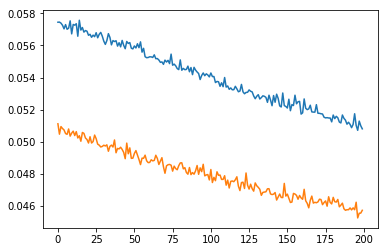

In [169]:
plt.plot(loss_all5[300:])
plt.plot(loss_all[800:])

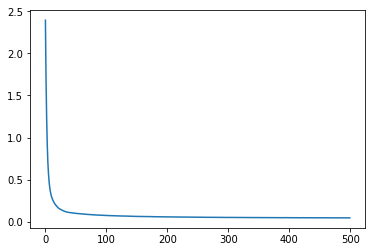

In [167]:
plt.plot(loss_all[500:])

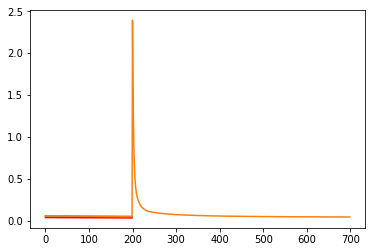

In [162]:
plt.plot(loss_all2[300:],color='red')
plt.plot(loss_all5[300:])
plt.plot(loss_all[300:])

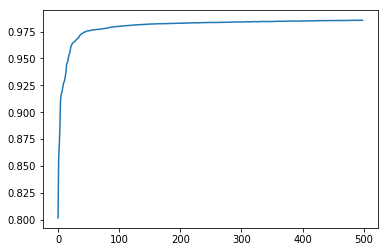

In [87]:
plt.plot(acc_all[1:])

In [170]:
device = 'cpu'
model = model.to(device)

In [171]:
y_hat = model(test_data.x.to(device), test_data.edge_index.to(device))
y_hat = y_hat.detach().numpy()
y_hat = np.argmax(y_hat, -1)

In [172]:
test_y = test_data.y.numpy()

In [173]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.983720,0.922467,0.952109,15000.000000
1,0.993444,0.998099,0.995766,38408.000000
2,0.995793,0.998636,0.997212,47641.000000
3,0.809735,0.935264,0.867984,587.000000
4,0.000000,0.000000,0.000000,11.000000
5,0.957770,0.981513,0.969496,2380.000000
6,0.879592,0.974562,0.924645,1769.000000
7,0.970280,0.957447,0.963821,1739.000000
8,0.964755,0.978788,0.971721,1650.000000
9,0.992306,0.997595,0.994944,69037.000000


In [141]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.869778,0.936867,0.902077,15000.000000
1,0.974326,0.998959,0.986489,38408.000000
2,0.999154,0.991667,0.995396,47641.000000
3,0.287879,0.032368,0.058193,587.000000
4,0.000000,0.000000,0.000000,11.000000
5,0.942370,0.487815,0.642857,2380.000000
6,0.864906,0.962691,0.911182,1769.000000
7,0.941756,0.660150,0.776200,1739.000000
8,0.723935,0.967879,0.828320,1650.000000
9,0.993821,0.990121,0.991968,69037.000000


In [91]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.992756,0.972173,0.982357,150000.000000
1,0.998125,0.997995,0.998060,38408.000000
2,0.982493,0.997733,0.990054,47641.000000
3,0.974026,0.383305,0.550122,587.000000
4,0.000000,0.000000,0.000000,11.000000
5,0.976401,0.973529,0.974963,2380.000000
6,0.726964,0.967778,0.830262,1769.000000
7,0.925347,0.919494,0.922411,1739.000000
8,0.920833,0.937576,0.929129,1650.000000
9,0.966387,0.997393,0.981645,69037.000000


In [48]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.993700,0.974847,0.984183,150000.000000
1,0.999271,0.998828,0.999049,38408.000000
2,0.985460,0.998720,0.992046,47641.000000
3,0.767857,0.659284,0.709441,587.000000
4,0.333333,0.272727,0.300000,11.000000
5,0.975904,0.986975,0.981408,2380.000000
6,0.789220,0.927077,0.852612,1769.000000
7,0.970132,0.971248,0.970690,1739.000000
8,0.959644,0.980000,0.969715,1650.000000
9,0.967860,0.998450,0.982917,69037.000000


In [57]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.966215,0.992753,0.979304,150000.000000
1,0.999713,0.999297,0.999505,38408.000000
2,0.987681,0.994605,0.991131,47641.000000
3,0.971963,0.708688,0.819704,587.000000
4,0.428571,0.272727,0.333333,11.000000
5,0.997467,0.992857,0.995157,2380.000000
6,0.967412,0.587337,0.730918,1769.000000
7,0.985690,0.990224,0.987952,1739.000000
8,0.971839,0.983030,0.977403,1650.000000
9,0.995700,0.945855,0.970138,69037.000000


In [45]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.973378,0.990373,0.981802,150000.000000
1,0.999661,0.999427,0.999544,38408.000000
2,0.987626,0.995130,0.991364,47641.000000
3,0.911654,0.826235,0.866845,587.000000
4,0.428571,0.272727,0.333333,11.000000
5,0.996629,0.993697,0.995161,2380.000000
6,0.936669,0.836066,0.883513,1769.000000
7,0.986819,0.990224,0.988519,1739.000000
8,0.971856,0.983636,0.977711,1650.000000
9,0.993705,0.951157,0.971965,69037.000000


In [37]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.974369,0.988887,0.981574,150000.000000
1,0.999740,0.999245,0.999492,38408.000000
2,0.987328,0.999265,0.993261,47641.000000
3,0.946309,0.720613,0.818182,587.000000
4,0.300000,0.272727,0.285714,11.000000
5,0.997890,0.993697,0.995789,2380.000000
6,0.874652,0.887507,0.881033,1769.000000
7,0.988466,0.985624,0.987043,1739.000000
8,0.969406,0.979394,0.974374,1650.000000
9,0.993071,0.950809,0.971481,69037.000000


In [28]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.995819,0.974953,0.985276,150000.000000
1,0.999297,0.999141,0.999219,38408.000000
2,0.986998,0.999097,0.993011,47641.000000
3,0.907285,0.933560,0.920235,587.000000
4,0.750000,0.272727,0.400000,11.000000
5,0.965531,0.988655,0.976957,2380.000000
6,0.756506,0.969474,0.849851,1769.000000
7,0.980496,0.953997,0.967065,1739.000000
8,0.938799,0.985455,0.961561,1650.000000
9,0.967318,0.999797,0.983290,69037.000000


In [37]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.945449,0.976333,0.960643,15000.000000
1,0.997868,0.994939,0.996401,166967.000000
accuracy,0.993405,0.993405,0.993405,0.993405
macro avg,0.971658,0.985636,0.978522,181967.000000
weighted avg,0.993547,0.993405,0.993454,181967.000000


In [29]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.966578,0.973667,0.970110,15000.000000
1,0.997633,0.996975,0.997304,166967.000000
accuracy,0.995054,0.995054,0.995054,0.995054
macro avg,0.982106,0.985321,0.983707,181967.000000
weighted avg,0.995073,0.995054,0.995062,181967.000000


In [61]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.810716,0.973400,0.884641,15000.000000
1,0.999792,0.999427,0.999609,38408.000000
2,0.999685,0.999244,0.999465,47641.000000
3,0.825561,0.814310,0.819897,587.000000
4,0.625000,0.454545,0.526316,11.000000
5,0.994558,0.998319,0.996435,2380.000000
6,0.920703,0.977954,0.948465,1769.000000
7,0.993031,0.983324,0.988154,1739.000000
8,0.988540,0.993333,0.990931,1650.000000
9,0.998029,0.953605,0.975311,69037.000000


In [54]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.990507,0.966867,0.978544,15000.000000
1,0.999818,0.999427,0.999622,38408.000000
2,0.999601,0.999244,0.999423,47641.000000
3,0.851064,0.954003,0.899598,587.000000
4,0.714286,0.454545,0.555556,11.000000
5,0.995802,0.996639,0.996220,2380.000000
6,0.913730,0.981911,0.946594,1769.000000
7,0.991917,0.987924,0.989916,1739.000000
8,0.987923,0.991515,0.989716,1650.000000
9,0.996736,0.999652,0.998192,69037.000000


In [45]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.991852,0.965733,0.978618,15000.000000
1,0.999870,0.999375,0.999622,38408.000000
2,0.999580,0.999223,0.999402,47641.000000
3,0.850227,0.957411,0.900641,587.000000
4,0.714286,0.454545,0.555556,11.000000
5,0.994966,0.996639,0.995802,2380.000000
6,0.911904,0.983041,0.946137,1769.000000
7,0.991917,0.987924,0.989916,1739.000000
8,0.987326,0.991515,0.989416,1650.000000
9,0.996492,0.999942,0.998214,69037.000000


In [28]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.987666,0.939533,0.962998,15000.000000
1,0.999479,0.999141,0.999310,38408.000000
2,0.995668,0.998594,0.997129,47641.000000
3,0.893401,0.899489,0.896435,587.000000
4,0.000000,0.000000,0.000000,11.000000
5,0.985816,0.992857,0.989324,2380.000000
6,0.838600,0.975127,0.901725,1769.000000
7,0.969248,0.978723,0.973963,1739.000000
8,0.979616,0.990303,0.984931,1650.000000
9,0.995670,0.999218,0.997441,69037.000000


In [237]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.995258,0.963852,0.979303,13500.000000
1,0.968244,0.995850,0.981853,14941.000000
accuracy,0.980662,0.980662,0.980662,0.980662
macro avg,0.981751,0.979851,0.980578,28441.000000
weighted avg,0.981066,0.980662,0.980643,28441.000000


In [179]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.902622,0.986667,0.942775,13500.00000
1,0.998333,0.998000,0.998166,3000.00000
2,0.995684,0.999667,0.997671,3000.00000
3,0.886525,0.426621,0.576037,293.00000
4,0.500000,0.400000,0.444444,5.00000
5,0.998305,0.989916,0.994093,1190.00000
6,0.993435,0.512994,0.676602,885.00000
7,0.993056,0.986207,0.989619,870.00000
8,0.979641,0.991515,0.985542,825.00000
9,0.948210,0.830000,0.885176,3000.00000


In [169]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.983694,0.974148,0.978898,13500.000000
1,0.998334,0.998667,0.998500,3000.000000
2,0.996013,0.999333,0.997671,3000.000000
3,0.724868,0.935154,0.816692,293.000000
4,1.000000,0.600000,0.750000,5.000000
5,0.994152,1.000000,0.997067,1190.000000
6,0.869177,0.990960,0.926082,885.000000
7,0.990741,0.983908,0.987313,870.000000
8,0.977273,0.990303,0.983745,825.000000
9,0.982261,0.941333,0.961362,3000.000000


In [65]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.993342,0.950370,0.971381,13500.000000
1,0.993369,0.998667,0.996011,3000.000000
2,0.995346,0.998000,0.996671,3000.000000
3,0.686717,0.935154,0.791908,293.000000
4,0.750000,0.600000,0.666667,5.000000
5,0.983471,1.000000,0.991667,1190.000000
6,0.849462,0.981921,0.910901,885.000000
7,0.984813,0.968966,0.976825,870.000000
8,0.972586,0.989091,0.980769,825.000000
9,0.908123,0.995000,0.949578,3000.000000


In [176]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.899637,0.918296,0.908871,13500.000000
1,0.924766,0.907436,0.916019,14941.000000
accuracy,0.912591,0.912591,0.912591,0.912591
macro avg,0.912202,0.912866,0.912445,28441.000000
weighted avg,0.912838,0.912591,0.912626,28441.000000


In [30]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.523932,0.952333,0.675973,3000.000000
1,0.999584,0.801000,0.889341,3000.000000
2,0.953615,0.993667,0.973229,3000.000000
3,0.972222,0.358362,0.523691,293.000000
4,0.000000,0.000000,0.000000,5.000000
5,0.998724,0.657983,0.793313,1190.000000
6,0.000000,0.000000,0.000000,885.000000
7,0.974114,0.821839,0.891521,870.000000
8,0.985384,0.980606,0.982989,825.000000
9,0.989789,0.937000,0.962671,3000.000000


In [30]:
inferrence(model, subgraph_loader)

100%|██████████| 28/28 [00:00<00:00, 34.64it/s]


[2 0 0 ... 0 0 0]
tensor([2, 0, 0,  ..., 0, 0, 0])
              precision    recall  f1-score   support

           0     0.8596    0.9609    0.9075     13500
           1     0.9931    0.9647    0.9787      3000
           2     0.9226    0.9927    0.9563      3000
           3     0.6329    0.9590    0.7626       293
           4     1.0000    0.2000    0.3333         5
           5     0.9838    0.5109    0.6726      1190
           6     0.6667    0.0045    0.0090       885
           7     0.9647    0.9747    0.9697       870
           8     0.9794    0.9818    0.9806       825
           9     0.9849    0.8673    0.9224      3000
          10     0.9980    0.9462    0.9714      1544
          11     0.0000    0.0000    0.0000         2
          12     0.5710    0.8186    0.6727       226
          13     0.0000    0.0000    0.0000        98
          14     0.0000    0.0000    0.0000         3

    accuracy                         0.9017     28441
   macro avg     0.7038    0.

In [107]:
inferrence(model, subgraph_loader)


100%|██████████| 22/22 [00:00<00:00, 32.48it/s]


[0 1 2 ... 1 0 2]
tensor([0, 1, 2,  ..., 1, 0, 2])
              precision    recall  f1-score   support

           0     0.9778    0.9412    0.9592      7500
           1     0.9793    0.9893    0.9843      9240
           2     0.9652    0.9890    0.9770      3000
           3     0.8594    0.9354    0.8958       294
           4     1.0000    0.4000    0.5714         5
           5     0.9448    0.9889    0.9663      2075
           6     0.9156    0.8960    0.9057       327

    accuracy                         0.9709     22441
   macro avg     0.9489    0.8771    0.8942     22441
weighted avg     0.9712    0.9709    0.9709     22441

[[7059  173  104   45    0   94   25]
 [  95 9141    0    0    0    3    1]
 [  25    7 2967    0    0    0    1]
 [  19    0    0  275    0    0    0]
 [   2    1    0    0    2    0    0]
 [  15    6    2    0    0 2052    0]
 [   4    6    1    0    0   23  293]]


In [158]:
inferrence(model, subgraph_loader)

100%|██████████| 28/28 [00:01<00:00, 17.11it/s]


[1 0 0 ... 0 0 0]
tensor([1, 0, 0,  ..., 0, 0, 0])
              precision    recall  f1-score   support

           0     0.8286    0.9610    0.8899     13500
           1     0.9589    0.8204    0.8842     14941

    accuracy                         0.8871     28441
   macro avg     0.8937    0.8907    0.8871     28441
weighted avg     0.8970    0.8871    0.8869     28441

[[12974   526]
 [ 2684 12257]]


In [523]:
inferrence(model, subgraph_loader)

100%|██████████| 22/22 [00:05<00:00,  4.05it/s]

[0 1 2 ... 1 0 2]
tensor([0, 1, 2,  ..., 1, 0, 2])
              precision    recall  f1-score   support

           0     0.9142    0.9667    0.9397      7500
           1     0.9942    0.9661    0.9800      9240
           2     0.9657    0.9753    0.9705      3000
           3     0.8132    0.9626    0.8816       294
           4     1.0000    0.6000    0.7500         5
           5     0.9780    0.8578    0.9140      2075
           6     0.9366    0.9480    0.9422       327

    accuracy                         0.9571     22441
   macro avg     0.9431    0.8967    0.9111     22441
weighted avg     0.9590    0.9571    0.9573     22441

[[7250   45  104   65    0   17   19]
 [ 312 8927    0    0    0    0    1]
 [  51    1 2926    0    0   21    1]
 [  11    0    0  283    0    0    0]
 [   1    1    0    0    3    0    0]
 [ 292    3    0    0    0 1780    0]
 [  13    2    0    0    0    2  310]]


In [515]:
inferrence(model, subgraph_loader)

100%|██████████| 22/22 [00:00<00:00, 24.86it/s]


[0 1 2 ... 1 0 2]
tensor([0, 1, 2,  ..., 1, 0, 2])
              precision    recall  f1-score   support

           0     0.9908    0.9437    0.9667      7500
           1     0.9826    0.9963    0.9894      9240
           2     0.9646    0.9890    0.9766      3000
           3     0.8304    0.9660    0.8931       294
           4     1.0000    0.6000    0.7500         5
           5     0.9462    0.9908    0.9680      2075
           6     0.9162    0.9358    0.9259       327

    accuracy                         0.9759     22441
   macro avg     0.9472    0.9174    0.9242     22441
weighted avg     0.9766    0.9759    0.9759     22441

[[7078  148  105   58    0   86   25]
 [  18 9206    0    0    0   15    1]
 [  20    7 2967    0    0    5    1]
 [  10    0    0  284    0    0    0]
 [   1    1    0    0    3    0    0]
 [  11    4    3    0    0 2056    1]
 [   6    3    1    0    0   11  306]]


In [463]:
inferrence(model, subgraph_loader)


100%|██████████| 18/18 [00:00<00:00, 30.26it/s]

[2 1 6 ... 1 1 7]
tensor([2, 1, 6,  ..., 1, 1, 7])
              precision    recall  f1-score   support

           0     0.7709    0.9249    0.8409      2998
           1     0.9997    0.9750    0.9872      3000
           2     0.9800    0.9987    0.9893      2998
           3     0.7153    0.7201    0.7177       293
           4     0.0769    0.4000    0.1290         5
           5     0.7298    0.1748    0.2820      1190
           6     0.3454    0.5186    0.4146       885
           7     0.9564    0.9069    0.9310       870
           8     0.9768    0.9697    0.9732       825
           9     0.9665    0.9454    0.9558      2987
          10     0.9980    0.9812    0.9895      1544
          11     0.0000    0.0000    0.0000         2

    accuracy                         0.8808     17597
   macro avg     0.7096    0.7096    0.6842     17597
weighted avg     0.8921    0.8808    0.8727     17597

[[2773    1   60   83   24    7   13    5    6   24    2    0]
 [   2 2925    0   

In [538]:
y_hat = model(test_data.x.to(device), test_data.edge_index.to(device))

In [539]:
y_hat = y_hat.detach().numpy()
y_hat = np.argmax(y_hat, -1)

In [540]:
len(y_hat)

22441

In [541]:
classification_report(test_y, y_hat, digits=4)

'              precision    recall  f1-score   support\n\n           0     0.9189    0.9665    0.9421      7500\n           1     0.9941    0.9661    0.9799      9240\n           2     0.9649    0.9907    0.9776      3000\n           3     0.8109    0.9626    0.8802       294\n           4     1.0000    0.6000    0.7500         5\n           5     0.9873    0.8607    0.9197      2075\n           6     0.9366    0.9480    0.9422       327\n\n    accuracy                         0.9594     22441\n   macro avg     0.9447    0.8992    0.9131     22441\nweighted avg     0.9612    0.9594    0.9595     22441\n'

In [137]:
y_hat = model(all_data.x.to(device), all_data.edge_index.to(device))

  0%|          | 0/186 [46:03<?, ?it/s]


RuntimeError: [enforce fail at CPUAllocator.cpp:68] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 8703520240 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
y_hat = y_hat.detach().numpy()
y_hat = np.argmax(y_hat, -1)

In [120]:
classification_report(test_y, y_hat[all_data.test_mask], digits=4)

IndexError: index 171153 is out of bounds for axis 0 with size 28441

In [96]:
from tqdm import tqdm

In [138]:
subgraph_loader2 = NeighborLoader(copy.copy(all_data), input_nodes=None,num_neighbors=[-1], batch_size=1024, shuffle=False)
subgraph_loader2.data.num_nodes = all_data.num_nodes
subgraph_loader2.data.n_id = torch.arange(all_data.num_nodes)

In [139]:
def inferrence2(model, subgraph_loader):
    pbar = tqdm(total=len(subgraph_loader))
    for i, batch in enumerate(subgraph_loader):
        batch = batch.to(device)
        y_hat = model(batch.x.to(device), batch.edge_index.to(device))[:batch.batch_size]
        np.save('unsw_yhat/y_hat_batch' + str(i), y_hat.detach().numpy())
        pbar.update(1)
    pbar.close()

In [140]:
def test(data, loader):
    xs = []
    for i in range(len(loader)):
        y_hat = np.load('unsw_yhat/y_hat_batch' + str(i) + '.npy')
        xs.append(y_hat)
    y_hat = np.concatenate(xs, 0)
    y_hat = np.argmax(y_hat, -1)
    y = data.y.to(device)
    test_mask = data.test_mask 
    f1 = f1_score(y[test_mask], y_hat[test_mask], average='weighted')
    pr = precision_score(y[test_mask], y_hat[test_mask], average='weighted')
    cr1 = classification_report(y[test_mask], y_hat[test_mask], digits=4)
    cf = confusion_matrix(y[test_mask], y_hat[test_mask])
    print("测试集结果：")
    print(cr1)
    print(cf)
    
    train_mask = data.train_mask
    f1 = f1_score(y[train_mask], y_hat[train_mask], average='weighted')
    pr = precision_score(y[train_mask], y_hat[train_mask], average='weighted')
    cr1 = classification_report(y[train_mask], y_hat[train_mask], digits=4)
    cf = confusion_matrix(y[train_mask], y_hat[train_mask])
    print("训练集结果：")
    print(cr1)
    print(cf)
    return f1, pr

In [141]:
device = 'cpu'

In [142]:
model = model.to(device)

In [159]:
inferrence2(model, subgraph_loader2)

 55%|█████▍    | 102/186 [08:03<17:47, 12.71s/it]

KeyboardInterrupt: 

In [ ]:
test(all_data, subgraph_loader2)

In [135]:
all_data_label = all_data.y.numpy()

In [136]:
all_data_label[all_data_label != 0] = 1
all_data.y = torch.LongTensor(all_data_label)

In [109]:
all_data

Data(x=[189603, 78], edge_index=[2, 108609698], y=[189603], num_nodes=189603, train_mask=[161162], test_mask=[28441])

In [110]:
subgraph_loader2 = NeighborLoader(all_data, input_nodes=all_data.test_mask,
                                 num_neighbors=hop, batch_size=500, shuffle=False)

In [73]:
train_data = train_data.to('cpu')
test_data = test_data.to('cpu')

In [74]:
x_train = train_data.x.numpy()
y_train = train_data.y.numpy()

In [75]:
x_test = test_data.x.numpy()
y_test = test_data.y.numpy()

In [76]:
from catboost import CatBoostClassifier

In [77]:
from sklearn.ensemble._forest import RandomForestClassifier

In [90]:
cbc = CatBoostClassifier(n_estimators=100)

In [91]:
cbc.fit(x_train, y_train)

Learning rate set to 0.5
0:	learn: 0.4805458	total: 55ms	remaining: 5.45s
1:	learn: 0.3225481	total: 87.9ms	remaining: 4.31s
2:	learn: 0.2275914	total: 121ms	remaining: 3.91s
3:	learn: 0.1780775	total: 154ms	remaining: 3.69s
4:	learn: 0.1261871	total: 190ms	remaining: 3.61s
5:	learn: 0.1100746	total: 220ms	remaining: 3.45s
6:	learn: 0.0897102	total: 252ms	remaining: 3.34s
7:	learn: 0.0745446	total: 287ms	remaining: 3.3s
8:	learn: 0.0665954	total: 321ms	remaining: 3.24s
9:	learn: 0.0586550	total: 357ms	remaining: 3.21s
10:	learn: 0.0536122	total: 387ms	remaining: 3.13s
11:	learn: 0.0494401	total: 428ms	remaining: 3.14s
12:	learn: 0.0446124	total: 465ms	remaining: 3.11s
13:	learn: 0.0434772	total: 492ms	remaining: 3.02s
14:	learn: 0.0411160	total: 526ms	remaining: 2.98s
15:	learn: 0.0390528	total: 555ms	remaining: 2.91s
16:	learn: 0.0379762	total: 585ms	remaining: 2.86s
17:	learn: 0.0357098	total: 614ms	remaining: 2.79s
18:	learn: 0.0334713	total: 646ms	remaining: 2.75s
19:	learn: 0.0319

In [92]:
y_pred = cbc.predict(x_test)

In [93]:
classification_report(y_test, y_pred, digits=4)

'              precision    recall  f1-score   support\n\n           0     0.4211    0.9788    0.5889      7500\n           1     0.9154    0.4870    0.6358      9240\n           2     1.0000    0.0007    0.0013      3000\n           3     0.8409    0.2517    0.3874       294\n           4     1.0000    0.4000    0.5714         5\n           5     0.0000    0.0000    0.0000      2075\n           6     0.0000    0.0000    0.0000       327\n\n    accuracy                         0.5311     22441\n   macro avg     0.5968    0.3026    0.3121     22441\nweighted avg     0.6626    0.5311    0.4640     22441\n'